In [13]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [14]:
INPUT_CSV = "papers.csv"

def Build_Directed_Graph(csv_file):
    G = nx.DiGraph()
    with open(csv_file, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            paper_id = row["paperId"].strip()
            title = row["title"].strip()
            refs = row["references"].split(";") if row["references"] else []

            G.add_node(paper_id, title=title)
            for ref_id in refs:
                ref_id = ref_id.strip()
                if ref_id:
                    G.add_edge(paper_id, ref_id)
    print(f"Graph built with {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

G = Build_Directed_Graph(INPUT_CSV)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
print(f"Graph after removing {len(isolated_nodes)} isolated nodes: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph built with 150 nodes, 107 edges
Graph after removing 118 isolated nodes: 32 nodes, 107 edges


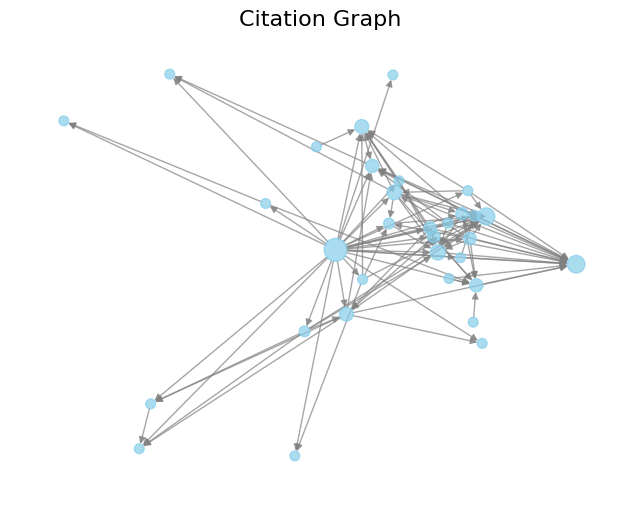

In [15]:
# node size depends on degree (for better visualization)
node_sizes = [max(50, 10 * G.degree(n)) for n in G.nodes()]

pos = nx.spring_layout(G, seed=42, k=0.5, iterations=100)

plt.figure(figsize=(8, 6))
nx.draw_networkx(
    G,
    pos,
    with_labels=False,     
    node_size=node_sizes,
    node_color="skyblue",
    edge_color="gray",
    alpha=0.7,
    arrowsize=10
)

plt.title("Citation Graph", fontsize=16)
plt.axis("off")
plt.show()

In [16]:
def compute_hits(G, tolerance=1e-6, max_iterations=1000):
    nodes = list(G.nodes())

    # Initialize Hub and Authority Score with 1.0
    hub = {n: 1.0 for n in nodes}
    auth = {n: 1.0 for n in nodes}

    differences = []
    
    for iteration in range(max_iterations):
        auth_new = {n: sum(hub[m] for m in G.predecessors(n)) for n in nodes}
        hub_new = {n: sum(auth_new[m] for m in G.successors(n)) for n in nodes}
        norm = sum(v**2 for v in auth_new.values())**0.5
        for n in nodes:
            auth_new[n] /= norm
        norm = sum(v**2 for v in hub_new.values())**0.5   
        for n in nodes:
                hub_new[n] /= norm

        diff = sum(abs(auth_new[n]-auth[n]) + abs(hub_new[n]-hub[n]) for n in nodes)
        differences.append(diff)
        hub, auth = hub_new, auth_new
        if diff < tolerance:
            print(f"HITS converged after {iteration+1} iterations.")
            last_iteration = iteration + 1
            break
    return hub, auth , differences , last_iteration


HITS converged after 13 iterations.


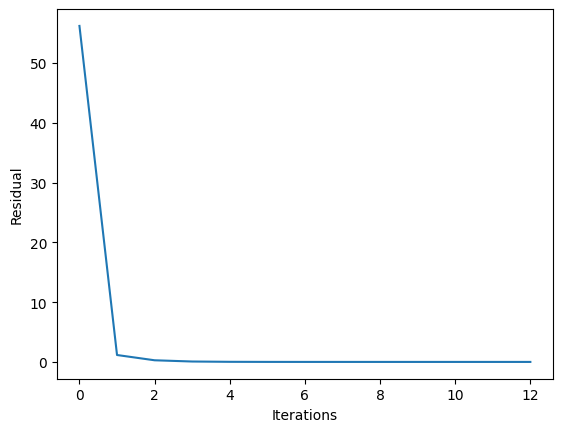

In [17]:
hub_scores, auth_scores , Differences , iterations = compute_hits(G)
plt.plot(np.arange(0,iterations),Differences)
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.show()

In [18]:
top_papers_by_authorities = sorted(auth_scores.items(), key=lambda x: x[1], reverse=True)[:10]
top_papers_by_hubs = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 papers by Authority Scores:")
for paper_id, score in top_papers_by_authorities:
    print(f"{paper_id[:8]} - {G.nodes[paper_id]['title'][:60]}... | Score: {score:.4f}")

print("\nTop 10 papers by Hubs Scores:")
for paper_id, score in top_papers_by_hubs:
    print(f"{paper_id[:8]} - {G.nodes[paper_id]['title'][:60]}... | Score: {score:.4f}")

Top 10 papers by Authority Scores:
2e9d221c - Long Short-Term Memory... | Score: 0.4398
fa72afa9 - Neural Machine Translation by Jointly Learning to Align and ... | Score: 0.4066
0b544dfe - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 0.3702
a6cb3667 - Adam: A Method for Stochastic Optimization... | Score: 0.3051
2c03df8b - Deep Residual Learning for Image Recognition... | Score: 0.2668
6471fd1c - Generating Sequences With Recurrent Neural Networks... | Score: 0.1906
93499a7c - Effective Approaches to Attention-based Neural Machine Trans... | Score: 0.1858
47570e7f - Grammar as a Foreign Language... | Score: 0.1839
b60abe57 - Deep Recurrent Models with Fast-Forward Connections for Neur... | Score: 0.1665
c6850869 - Google's Neural Machine Translation System: Bridging the Gap... | Score: 0.1477

Top 10 papers by Hubs Scores:
arXiv:17 - Attention is All you Need... | Score: 0.6100
c6850869 - Google's Neural Machine Translation System: Bridging the Gap... | Sco

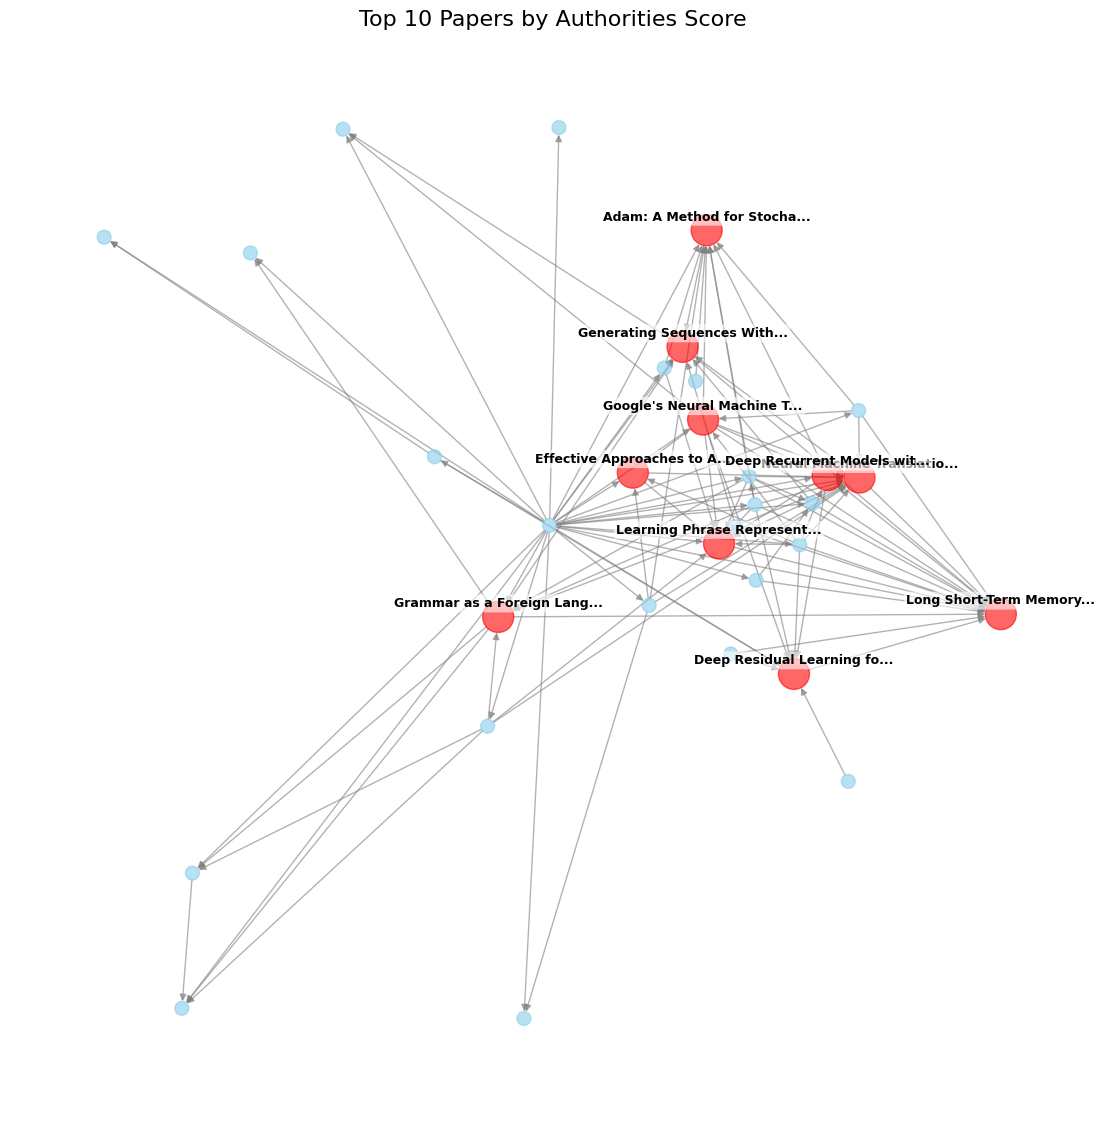

In [19]:
top_nodes = [paper_id for paper_id, _ in top_papers_by_authorities]
node_colors = ["red" if n in top_nodes else "skyblue" for n in G.nodes()]
node_sizes = [500 if n in top_nodes else 100 for n in G.nodes()]
pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)

plt.figure(figsize=(14, 14))
nx.draw_networkx(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    alpha=0.6,
    arrowsize=10
)

for n in top_nodes:
    x, y = pos[n]
    plt.text(
        x, y + 0.02, 
        G.nodes[n]['title'][:25] + "...", 
        fontsize=9, 
        color="black", 
        fontweight="bold",
        ha="center",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.2")
    )

plt.title("Top 10 Papers by Authorities Score", fontsize=16)
plt.axis("off")
plt.show()

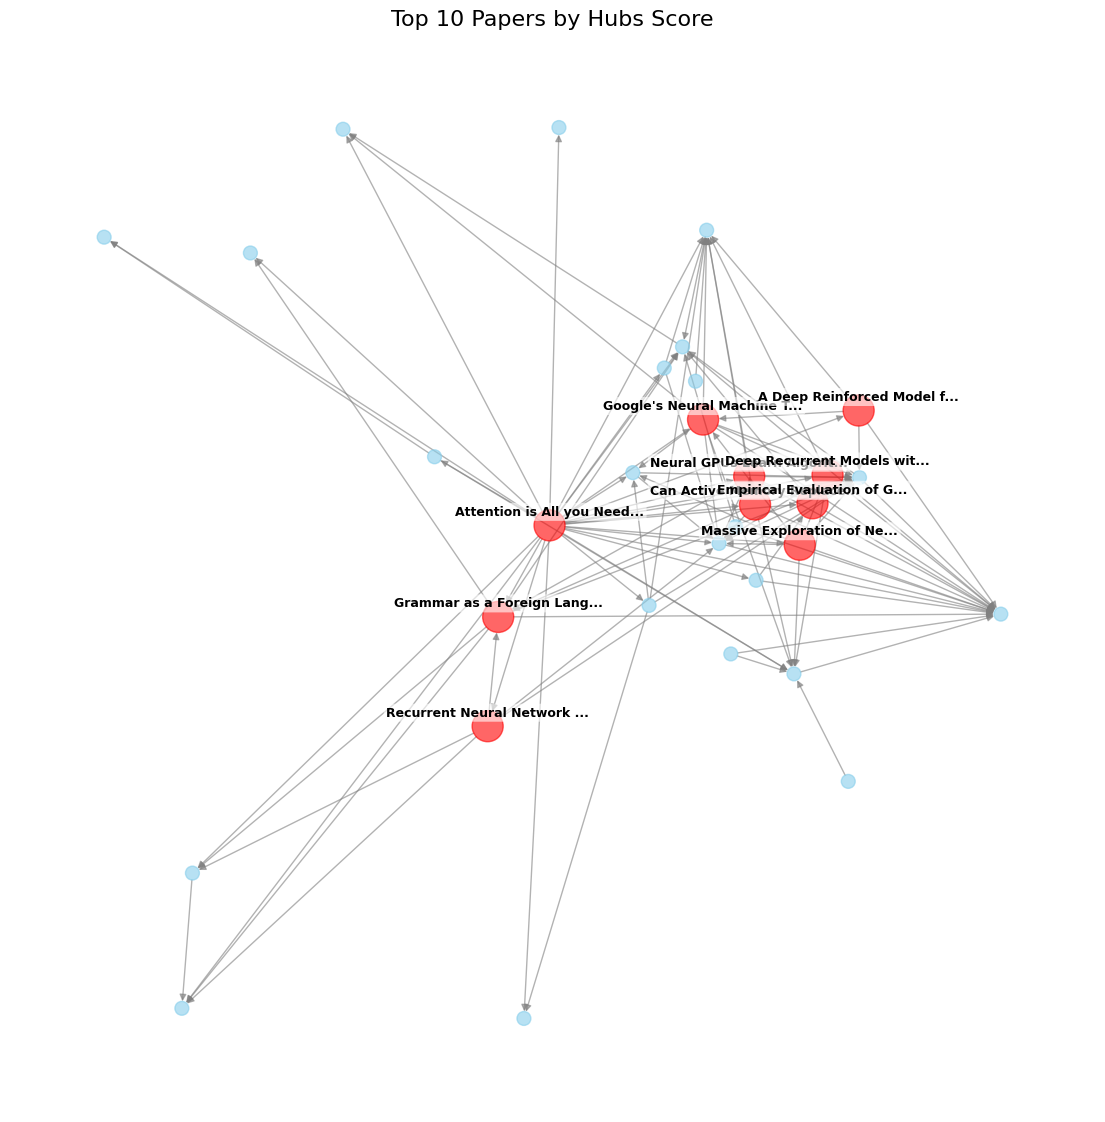

In [20]:
top_nodes = [paper_id for paper_id, _ in top_papers_by_hubs]
node_colors = ["red" if n in top_nodes else "skyblue" for n in G.nodes()]
node_sizes = [500 if n in top_nodes else 100 for n in G.nodes()]
pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)

plt.figure(figsize=(14, 14))
nx.draw_networkx(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    alpha=0.6,
    arrowsize=10
)

for n in top_nodes:
    x, y = pos[n]
    plt.text(
        x, y + 0.02, 
        G.nodes[n]['title'][:25] + "...", 
        fontsize=9, 
        color="black", 
        fontweight="bold",
        ha="center",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.2")
    )

plt.title("Top 10 Papers by Hubs Score", fontsize=16)
plt.axis("off")
plt.show()